In [36]:
import math
import nilearn as ni
from nilearn import plotting
from nilearn import image
from nilearn.image import math_img
from nilearn.image import index_img
from nilearn.regions import connected_regions
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.optimize import basinhopping

# Optimal Thresholding of Images
Load the Neurosynth images, then remove values < 0: 

In [2]:
wm = image.load_img("wm_optimized.nii")
action = image.load_img("action_optimized.nii")
ltm = image.load_img("ltm_optimized.nii")
perception = image.load_img("perception_optimized.nii")
pm = image.load_img("procedural_optimized.nii")

IMAGES = [wm, ltm, action, pm,  perception]
NAMES = ["wm", "ltm", "action", "procedural", "perception"]
COLORS = ["aqua", "orange", "darkorchid", "limegreen", "tomato"]

## What the maps look like

Here is what the maps look like, using the colors of the Stocco et al. (in press) paper:

/home/andrea/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


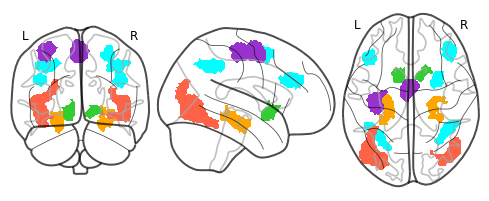

In [3]:
display = plotting.plot_glass_brain(None)
COLORS = ["aqua", "orange", "darkorchid", "limegreen", "tomato"]
for img, col in zip(IMAGES, COLORS):
    display.add_contours(img, levels=[0.0], filled=True, colors=col)

## Add Emotion

/home/andrea/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


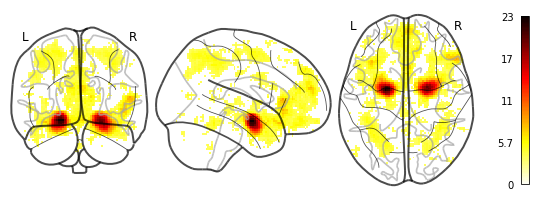

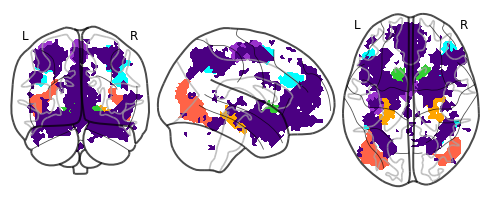

In [10]:
emotion = image.load_img("emotional_association-test_z_FDR_0.01.nii.gz")
plotting.plot_glass_brain(emotion, colorbar=True)
IMAGES = [wm, ltm, action, pm,  perception, emotion]
NAMES = ["wm", "ltm", "action", "procedural", "perception", "emotion"]
COLORS = ["aqua", "orange", "darkorchid", "limegreen", "tomato", "indigo"]
display = plotting.plot_glass_brain(None)
for img, col in zip(IMAGES, COLORS):
    display.add_contours(img, levels=[0.0], filled=True, colors=col)

## Setting Up the Thresholding Procedure

Define some basic functions, one to create thresholded images based on proportion of maximum inhtensity, and one to create the sum of each image's binary masks

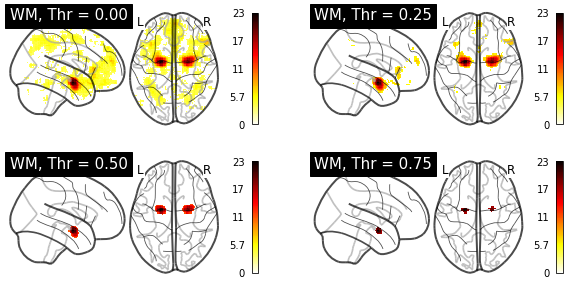

In [11]:
def percent_threshold(img, pc_threshold):
    """Thresholds an image at XX%"""
    v_max = np.max(img.dataobj)
    thr = v_max * pc_threshold
    return image.threshold_img(img, thr)

fig, axes = plt.subplots(2, 2, figsize=(10,5))
axes = [item for sublist in axes for item in sublist]
for i in range(0, 4):
    threshold = i/4.0
    plotting.plot_glass_brain(percent_threshold(emotion, threshold), 
                              title="WM, Thr = %.2f" % threshold, 
                              display_mode='xz', axes=axes[i],
                              colorbar=True)

And now, a function that uses the threshold to create the Sum of Binary Masks (SBM):

/home/andrea/.local/lib/python3.9/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


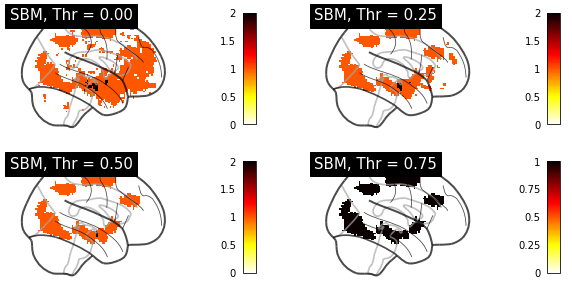

In [30]:
def sum_bin_masks(pc_threshold):
    """Calculates the sum of all binarized masks"""
    res = None
    if pc_threshold < 0:
        pc_threshold = 0
    if pc_threshold > 1:
        pc_threshold = 1
    for img in [wm, action, ltm, perception, pm, emotion]:
        if (img == emotion):
            partial = percent_threshold(img, pc_threshold)
        else:
            partial = img
        partial = math_img("np.where(i>0,1,0)", i = partial)
        if res == None:
            res = partial
        else:
            res = math_img("i1 + i2", i1=res, i2=partial)
    return res
                
        
fig, axes = plt.subplots(2, 2, figsize=(10,5))
axes = [item for sublist in axes for item in sublist]
for i in range(0, 4):
    threshold = i/4.0
    plotting.plot_glass_brain(sum_bin_masks(threshold), title="SBM, Thr = %.2f" % threshold, 
                              display_mode='x', axes=axes[i], colorbar=True)

## A General Loss Function
To define a loss function, it will be useful, later on, to refer to to total number of voxels $V_{SBM}$ that is present in the Summed Binary Mask when the height threshold is zero.

In [31]:
sbm0 = sum_bin_masks(0)
bsbm0 = math_img("np.where(i>0, 1, 0)", i = sbm0)
V_SBM = np.sum(bsbm0.dataobj)
V_SBM

14557

Now we can use Python's Optimization algorithm to find the best possible threshold). To do se, we need to define a loss function that needs to be minized. The loss function take as input the set of images created by apply different height and cluster thresholds (one for each of the five components), create binary mask versions of each of them, sum them up into a resulting Summed Binary Mask (SBM) image, and calculate a _loss_ value that is the sum of two penalties:

* A _size_ penalty, which is the ratio of the total number of voxels in the sum binary mask (SBM) at the final threshold and the total number of voxels in the SBM when the threshold is zero (that is, _V_(_H_=_H_*)/_V_(_H_=0)). This will push the algorithm the find the smallest possible threshold; and

* An _overlap_ penalty, which is maximum value of the intensity in the sum binary mask (SBM), i.e. the sum of the five binary masks, minus 1, i.e., |max(SBM)-1|. This will push the algorithm to reduce the overlap between masked images.

In addition, a third penalty value is added

* A _missing region_ penalty, which is equal to 1 for every one of the input regions that has no voxel remaining after applying the proper height and size thresholds.

To obtain properly smooth functions, the normalized form of the parameters will also be added.

### Implementation

To implement this procedure, we first need to define two functions, one that generates the SBM from the initial images and calculates the _missing region_ penalty, and one that calculates the overall loss function.  

In [45]:
def sbm_function(images):
    """Generates an SBM from component images and calculates the missing region penalty"""
    res = None
    missing_region_penalty = 0
    
    for img in images:
        partial = math_img("np.where(i>0,1,0)", i = img)
        
        # Check if all voxels have been removed
        if np.sum(partial.dataobj) == 0:
            missing_region_penalty += 1
        
        if res == None:
            res = partial
        else:
            res = math_img("i1 + i2", i1=res, i2=partial)
    
    return res, missing_region_penalty

def loss_function(images):
    """General loss function"""
    sbm, mr_penalty = sbm_function(images)
    
    H_max = np.max(sbm.dataobj)
    overlap_penalty = abs(H_max - 1)
    
    
    bsbm = math_img("np.where(i>0, 1, 0)", i = sbm)
    size_penalty = 1.0 - np.sum(bsbm.dataobj)/float(V_SBM)
    print("  --> Penalities: <MR: %d; OL: %d; SP = %.2f>" % (mr_penalty, overlap_penalty, size_penalty))
    
    
    return  overlap_penalty #+ size_penalty# + mr_penalty

# 1. Optimization: Height Threshold

Finally, having defined a loss function, we can built a target function that calculates the loss based on a specific height threshold. We can then use standard optimization algorithms to minimize the loss. In this case, we will be Powell's method (as opposed to Nelder-Mead), which allows for linear bounds of the variables.

In [48]:
def pheight_threshold(x):
    """Objective function to minimize"""
    thr = x
    images = IMAGES[0:5] + [percent_threshold(emotion, thr)]
    loss = loss_function(images) + thr
    print("H = % .3f, Loss = %.3f" % (thr, loss))
    return loss 

optimal = minimize_scalar(pheight_threshold, method="Bounded", bounds=(0.6, 1), options={"maxiter" : 25, "disp":True})

  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.753, Loss = 0.753
  --> Penalities: <MR: 0; OL: 0; SP = 0.57>
H =  0.847, Loss = 0.847
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.694, Loss = 0.694
  --> Penalities: <MR: 0; OL: 1; SP = 0.55>
H =  0.658, Loss = 1.658
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.717, Loss = 0.717
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.681, Loss = 0.681
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.672, Loss = 0.672
  --> Penalities: <MR: 0; OL: 1; SP = 0.56>
H =  0.667, Loss = 1.667
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.675, Loss = 0.675
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.670, Loss = 0.670
  --> Penalities: <MR: 0; OL: 1; SP = 0.56>
H =  0.669, Loss = 1.669
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.671, Loss = 0.671
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.670, Loss = 0.670
  --> Penalities: <MR: 0; OL: 0; SP = 0.56>
H =  0.669, Loss = 0.669
  --> Penalities: <MR: 0; OL: 0; S

In [50]:
optimal

     fun: 0.6691139766575902
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.6691139766575902

## Visualization of results


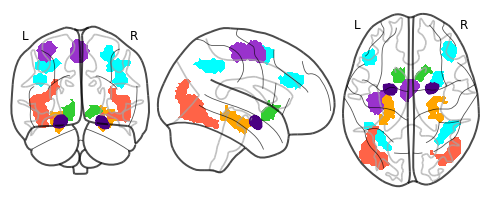

In [51]:
display = plotting.plot_glass_brain(None)
for i, img in enumerate(IMAGES):
    thr = 0
    if i == 5:
        thr = optimal.x * np.max(img.dataobj)

    display.add_contours(img, levels=[thr], filled=True, colors=COLORS[i])

## Save Emotional Region

Save the results to a file.

In [73]:
img = percent_threshold(emotion, optimal.x)
bin_img = math_img("np.where(i>0,1,0)", i = img)
bin_img.to_filename("emotion_.nii")

/home/andrea/.local/lib/python3.9/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


1

/home/andrea/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


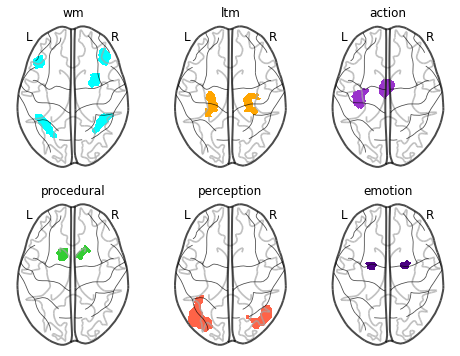

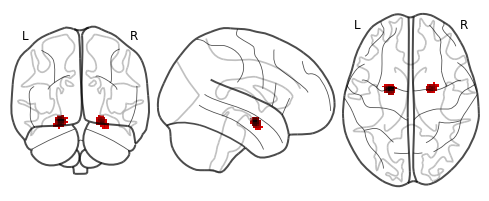

In [75]:
fig, axs = plt.subplots(2, math.floor(len(NAMES)/2), figsize=(8, len(NAMES)))
for i, name in enumerate(NAMES):   
    img = image.load_img("%s_optimized.nii" % name)
    d = plotting.plot_glass_brain(None, axes=axs.flatten()[i], display_mode='z')
    axs.flatten()[i].set_title(name)
    d.add_contours(img, levels=[0.001], filled=True, colors=COLORS[i])